<span style="font-size:24px; font-weight:bold;">Import libraries and read dataset</span>

In [2]:
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score







In [3]:
# Reads training metadata and features
training_data = pd.read_csv('train/train_metadata.csv')
training_af = pd.read_csv('train/Features/additional_features.csv')
training_ch = pd.read_csv('train/Features/color_histogram.csv')
training_hp = pd.read_csv('train/Features/hog_pca.csv')

# Reads testing metadata and features
test_data = pd.read_csv('test/test_metadata.csv')
test_af = pd.read_csv('test/Features/additional_features.csv')
test_ch = pd.read_csv('test/Features/color_histogram.csv')
test_hp = pd.read_csv('test/Features/hog_pca.csv')


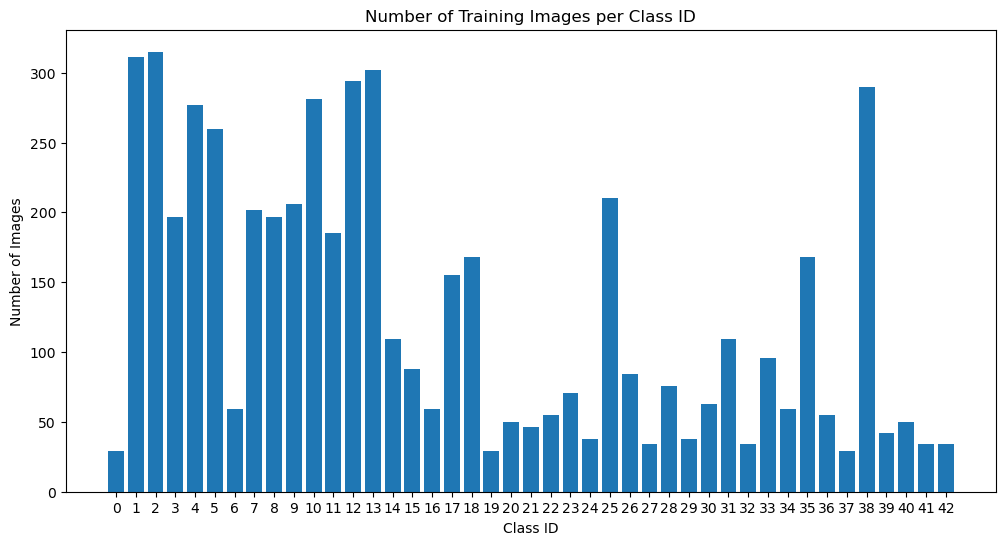

In [4]:
# Check to see any imbalance of result in the dataset
counts = training_data["ClassId"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(counts.index, counts.values)
ax.set_xlabel('Class ID')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Training Images per Class ID')
ax.set_xticks(counts.index)
plt.show()

<span style="font-size:24px; font-weight:bold;">Baseline Model (Without any engineered features)</span>




In [6]:
# Combined existing features into 1 df
combined_features = (
    training_data
    .merge(training_af, on='image_path', how='inner')
    .merge(training_ch, on='image_path', how='inner')
    .merge(training_hp, on='image_path', how='inner')
)
combined_features


,id,image_path,ClassId,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,...,hog_pca_10,hog_pca_11,hog_pca_12,hog_pca_13,hog_pca_14,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19
0,7218,img_000001.jpg,32,0.050293,63.748291,62.107910,62.850830,0.000000,0.000000,0.268901,...,-0.439643,-1.485862,-0.892584,-0.455376,-0.979620,0.450825,-0.213796,-0.882416,-0.309656,0.271686
1,6333,img_000002.jpg,13,0.034424,48.680664,52.872314,61.539307,0.000000,0.002267,0.657901,...,-0.190342,0.210740,-0.011180,0.138000,0.101737,-0.335682,-0.886182,0.507969,0.006536,0.471807
2,6867,img_000003.jpg,7,0.126709,99.174561,110.774658,127.348389,0.002243,0.143541,0.385766,...,0.521769,0.328718,-0.357041,-0.192591,0.377116,0.501386,-0.421448,0.081289,0.730258,-0.205895
3,7730,img_000004.jpg,4,0.026123,30.493896,26.616211,29.006592,0.000000,0.096069,0.947646,...,0.948256,-0.115478,0.146324,-0.296778,-0.595600,0.285638,-0.481589,-0.101580,-0.139084,0.586276
4,6338,img_000005.jpg,35,0.106934,116.836670,97.684814,79.495605,0.000000,0.000000,0.000000,...,1.007779,-0.219087,0.420509,-0.053858,0.601939,-0.520063,0.062209,0.248771,0.140214,0.292198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,456,img_005484.jpg,17,0.100586,97.798096,107.457275,139.611816,0.000000,0.005113,0.063918,...,-0.842139,-0.119560,0.169551,0.016671,-0.143923,-0.141590,0.172979,-0.356541,-0.167192,-0.452964
5484,4084,img_005485.jpg,4,0.034180,171.357422,156.866699,163.271484,0.000000,0.000000,0.000000,...,-0.096614,-0.411194,-0.047927,-0.044189,0.388909,-0.294122,-0.072038,0.171852,-0.131252,0.146278
5485,5117,img_005486.jpg,2,0.247559,144.043701,158.237793,180.798340,0.005808,0.045637,0.260545,...,0.165496,0.204292,0.056600,0.439432,0.459455,-0.542944,0.056787,-0.252209,-0.082190,-0.157411
5486,3334,img_005487.jpg,3,0.038818,89.712158,84.372314,83.712646,0.000000,0.504522,0.417509,...,-0.312279,-0.305216,0.010809,0.408131,-0.286114,0.211036,-0.284097,0.555815,-1.190879,0.073978


In [7]:
# Pre-processed data for training for baseline model

# Log columns with missing values
missing_columns = combined_features.columns[combined_features.isnull().any()].tolist()

# Handle missing values
for column in combined_features.columns:

    # Checks for initial missing values
    if combined_features[column].isnull().any():
        if column == 'ClassId' or combined_features[column].dtype == 'object':
            
            # For categorical/text data or ClassId: use mode
            mode_val = combined_features[column].mode(dropna=True)
            
            if not mode_val.empty:
                combined_features[column].fillna(mode_val[0], inplace=True)
                print(f"Filled missing values in {column} with mode: {mode_val[0]}")
                
            else:
                print(f"Warning: No valid mode for {column}. Consider alternative imputation.")
                
        elif pd.api.types.is_numeric_dtype(combined_features[column]):
            
            # For numeric data: use mean
            mean_val = combined_features[column].mean()
            combined_features[column].fillna(mean_val, inplace=True)
            print(f"Filled missing values in {column} with mean: {mean_val}")

# Standardises the combined features for easier comparison
numeric_columns = combined_features.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'ClassId' and col != 'id']
scaler = StandardScaler()
combined_features[numeric_columns] = scaler.fit_transform(combined_features[numeric_columns])

# Drop irrelevant columns for training
X = combined_features.drop(columns=['image_path', 'ClassId', "id"])
y = combined_features['ClassId']

# Stratified train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



# <span style="font-size:18px;">k-Nearest Neighbor</span>



In [9]:
# Train model using k-NN
# Fine-tunning parameters (neighbors, distance)
N = len(combined_features)
root = int(np.sqrt(N))  
k_values = list(range(1, root * 2 + 1, 2))  
param_grid = {
    'n_neighbors': k_values,
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Initialize KNN estimator
knn_base = KNeighborsClassifier(n_jobs=-1)

# Set up GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Run grid search
grid_search.fit(X_train, y_train)

# Display best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Apply best parameters
knn_base = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], metric = grid_search.best_params_['metric'] , n_jobs=-1)
cv_scores = cross_val_score(knn_base, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"5-fold CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Train on full training set and evaluate on test set
knn_base.fit(X_train, y_train)
y_pred = knn_base.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 222 candidates, totalling 1110 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1}
5-fold CV accuracy: 0.733 ± 0.010
Test accuracy: 0.788

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.82      0.81      0.81        62
           2       0.79      0.76      0.77        63
           3       0.62      0.64      0.63        39
           4       0.72      0.80      0.76        55
           5       0.64      0.75      0.69        52
           6       0.91      0.83      0.87        12
           7       0.80      0.88      0.83        40
           8       0.58      0.79      0.67        39
           9       0.86      0.76      0.81        41
          10       0.83      0.79      0.81        56
          11       0.70      0.62      0.66        37
          12       0.98      0.85      0.91        59
          13       0.95      0.87      0

# Engineer new feature


# <span style="font-size:18px;">Feature for shape</span>

In [12]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

# Define a shape-feature extractor
def extract_shape_feats(image_path):
    full_path = os.path.join(IMG_DIR, image_path)
    img = imread(full_path)
    gray = rgb2gray(img)
    # Binarize: foreground (sign) is True
    thresh = threshold_otsu(gray)
    binary = gray < thresh
    # Label connected regions
    lbl = label(binary)
    props = regionprops(lbl)
    if not props:
        # no regions found → zeros
        return [0, 0, 0, 0, 0]
    # pick the largest region
    p = max(props, key=lambda x: x.area)
    area        = p.area
    perimeter   = p.perimeter
    minr, minc, maxr, maxc = p.bbox
    aspect_rat  = (maxc - minc) / (maxr - minr) if (maxr - minr) > 0 else 0
    solidity    = p.solidity
    eccentricity = p.eccentricity
    return [image_path, area, perimeter, aspect_rat, solidity, eccentricity]

# <span style="font-size:18px;">Fill ratio + Circularity</span>

In [14]:
def extract_fill_circularity(image_path):
    full_path = os.path.join(IMG_DIR, image_path)
    img = imread(full_path)
    gray = rgb2gray(img)

    # Binarize with Otsu
    thresh = threshold_otsu(gray)
    binary = gray < thresh

    # Label and pick largest region
    lbl = label(binary)
    props = regionprops(lbl)
    if not props:
        return [0, 0]
    p = max(props, key=lambda x: x.area)

    area = p.area
    perimeter = p.perimeter if p.perimeter > 0 else 1

    # Fill ratio
    minr, minc, maxr, maxc = p.bbox
    bbox_area = (maxr - minr) * (maxc - minc) if (maxr - minr)*(maxc - minc)>0 else 1
    fill_ratio = area / bbox_area

    # Circularity
    circularity = 4 * np.pi * area / (perimeter ** 2)

    return [image_path, fill_ratio, circularity]



In [15]:
# Declare directory to access/save features
IMG_DIR = r'C:\Users\Admin\Documents\COMP30027-Proj2\train'


# Create new feature dataframe
shape_feats = training_data['image_path'].apply(extract_shape_feats).tolist()
circular_feats = training_data['image_path'].apply(extract_fill_circularity).tolist()
circular_cols = ['image_path', 'fill_ratio', 'circularity']
shape_cols = ['image_path', 'area', 'perimeter', 'aspect_ratio', 'solidity', 'eccentricity']
shape_df = pd.DataFrame(shape_feats, columns=shape_cols, index=training_data.index)
circular_df = pd.DataFrame(circular_feats, columns=circular_cols, index=training_data.index)
features_df = (training_data.merge(shape_df, on='image_path', how = 'inner')).drop(columns=['ClassId', "id"])

features_df


,image_path,area,perimeter,aspect_ratio,solidity,eccentricity
0,img_000001.jpg,765.0,200.669048,1.066667,0.796875,0.357246
1,img_000002.jpg,1959.0,289.775649,1.042553,0.850630,0.290758
2,img_000003.jpg,1414.0,342.024387,1.061224,0.554945,0.334300
3,img_000004.jpg,1796.0,332.509668,1.000000,0.813038,0.106708
4,img_000005.jpg,1006.0,279.888348,1.000000,0.870242,0.301442
...,...,...,...,...,...,...
5483,img_005484.jpg,509.0,128.041631,0.333333,0.708914,0.972386
5484,img_005485.jpg,1361.0,181.355339,1.000000,0.963199,0.553400
5485,img_005486.jpg,1648.0,565.167568,1.000000,0.356401,0.511259
5486,img_005487.jpg,1689.0,171.497475,1.133333,0.937292,0.333561


In [16]:
# Combined all features together
combined_df = (
    training_data
    .merge(training_af, on='image_path', how='inner')
    .merge(training_ch, on='image_path', how='inner')
    .merge(training_hp, on='image_path', how='inner')
    .merge(features_df, on='image_path', how='inner')
)

# Log columns with missing values
missing_columns = combined_df.columns[combined_df.isnull().any()].tolist()

# Handle missing values
for column in combined_df.columns:

    # Checks for initial missing values
    if combined_df[column].isnull().any():
        if column == 'ClassId' or combined_df[column].dtype == 'object':
            
            # For categorical/text data or ClassId: use mode
            mode_val = combined_df[column].mode(dropna=True)
            
            if not mode_val.empty:
                combined_df[column].fillna(mode_val[0], inplace=True)
                print(f"Filled missing values in {column} with mode: {mode_val[0]}")
                
            else:
                print(f"Warning: No valid mode for {column}. Consider alternative imputation.")
                
        elif pd.api.types.is_numeric_dtype(combined_df[column]):
            
            # For numeric data: use mean
            mean_val = combined_df[column].mean()
            combined_df[column].fillna(mean_val, inplace=True)
            print(f"Filled missing values in {column} with mean: {mean_val}")

# Standardises the combined features for easier comparison
numeric_columns = combined_df.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'ClassId' and col != 'id']
scaler = StandardScaler()
combined_df[numeric_columns] = scaler.fit_transform(combined_df[numeric_columns])

combined_df



,id,image_path,ClassId,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,...,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,area,perimeter,aspect_ratio,solidity,eccentricity
0,7218,img_000001.jpg,32,-0.572368,-0.391041,-0.379058,-0.481654,-0.092757,-0.409911,0.118950,...,1.102739,-0.534622,-2.283504,-0.810130,0.723680,-0.551304,-0.652672,0.296382,0.312606,-0.572062
1,6333,img_000002.jpg,13,-0.791843,-0.710490,-0.574687,-0.507331,-0.092757,-0.399719,1.414734,...,-0.821095,-2.216003,1.314514,0.017100,1.256734,0.023064,-0.308141,0.178169,0.724172,-0.930255
2,6867,img_000003.jpg,7,0.484485,0.360030,0.651803,0.781085,0.037730,0.235497,0.508236,...,1.226416,-1.053881,0.210357,1.910523,-0.548435,-0.239105,-0.106122,0.269702,-1.539702,-0.695678
3,7730,img_000004.jpg,4,-0.906645,-1.096067,-1.130844,-1.144259,-0.092757,0.022046,2.379893,...,0.698684,-1.204269,-0.262868,-0.363876,1.561641,-0.055346,-0.142910,-0.030443,0.436353,-1.921803
4,6338,img_000005.jpg,35,0.210986,0.734484,0.374533,-0.155781,-0.092757,-0.409911,-0.776775,...,-1.272101,0.155563,0.643765,0.366832,0.778317,-0.435372,-0.346371,-0.030443,0.874333,-0.872697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,456,img_005484.jpg,17,0.123197,0.330848,0.581534,1.021180,-0.092757,-0.386919,-0.563861,...,-0.346335,0.432556,-0.922651,-0.437414,-1.206544,-0.674451,-0.933486,-3.298690,-0.360860,2.741920
5484,4084,img_005485.jpg,4,-0.795219,1.890378,1.628126,1.484391,-0.092757,-0.409911,-0.776775,...,-0.719437,-0.180139,0.444715,-0.343384,0.389635,-0.264601,-0.727348,-0.030443,1.586045,0.484690
5485,5117,img_005486.jpg,2,2.155866,1.311300,1.657168,1.827534,0.245169,-0.204713,0.091116,...,-1.328069,0.142003,-0.652664,-0.215028,-0.419291,-0.126541,0.756661,-0.030443,-3.059828,0.257659
5486,3334,img_005487.jpg,3,-0.731065,0.159418,0.092547,-0.073219,-0.092757,1.858592,0.613975,...,0.516206,-0.710416,1.438329,-3.115611,0.197052,-0.106818,-0.765464,0.623207,1.387691,-0.699661


In [17]:
import pickle

# 1) Build imputation dicts
mode_vals = {}
mean_vals = {}
categorical_cols = []
numeric_cols   = numeric_columns.copy()  # from your code

for col in combined_df.columns:
    if col in numeric_cols:
        mean_vals[col] = combined_df[col].mean()
    else:
        categorical_cols.append(col)
        mode_vals[col] = combined_df[col].mode(dropna=True)[0]

# 2) Persist imputation statistics
with open('impute_stats.pkl', 'wb') as f:
    pickle.dump({
        'mean_vals': mean_vals,
        'mode_vals': mode_vals,
        'numeric_cols': numeric_cols,
        'categorical_cols': categorical_cols
    }, f)

# 3) Persist the fitted scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Saved imputation stats to 'impute_stats.pkl' and scaler to 'scaler.pkl'")


Saved imputation stats to 'impute_stats.pkl' and scaler to 'scaler.pkl'


# Test new Features


In [19]:
# Drop irrelevant columns for training
X = combined_df.drop(columns=['image_path', 'ClassId', "id"])
y = combined_df['ClassId']

# Stratified train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# <span style="font-size:18px;">0R (Baseline Model)</span>

In [21]:
# Initialize 0R (Zero-R) classifier
zero_r = DummyClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'strategy': ['most_frequent', 'stratified', 'uniform', 'constant'],
    'constant': [y_train.mode()[0]]  # using the most common class as constant prediction
}

# Perform GridSearchCV
grid_0r = GridSearchCV(
    zero_r,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_0r.fit(X_train, y_train)

# Retrieve best parameters
print("Best 0R params:", grid_0r.best_params_)
print(f"Best CV accuracy: {grid_0r.best_score_:.3f}")

# Evaluate on hold-out set
best_0r = grid_0r.best_estimator_
y_pred_0r = best_0r.predict(X_test)
print(f"0R Hold-out accuracy: {accuracy_score(y_test, y_pred_0r):.3f}")
print(f"0R Hold-out precision: {precision_score(y_test, y_pred_0r, average='macro', zero_division=0):.3f}")
print(f"0R Hold-out recall: {recall_score(y_test, y_pred_0r, average='macro', zero_division=0):.3f}")

print("0R Classification Report:\n", classification_report(y_test, y_pred_0r, zero_division=0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best 0R params: {'constant': 2, 'strategy': 'most_frequent'}
Best CV accuracy: 0.057
0R Hold-out accuracy: 0.057
0R Hold-out precision: 0.001
0R Hold-out recall: 0.023
0R Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        62
           2       0.06      1.00      0.11        63
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        55
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        39
           9       0.00      0.00      0.00        41
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        37
          12       0.00      0.00      0.0

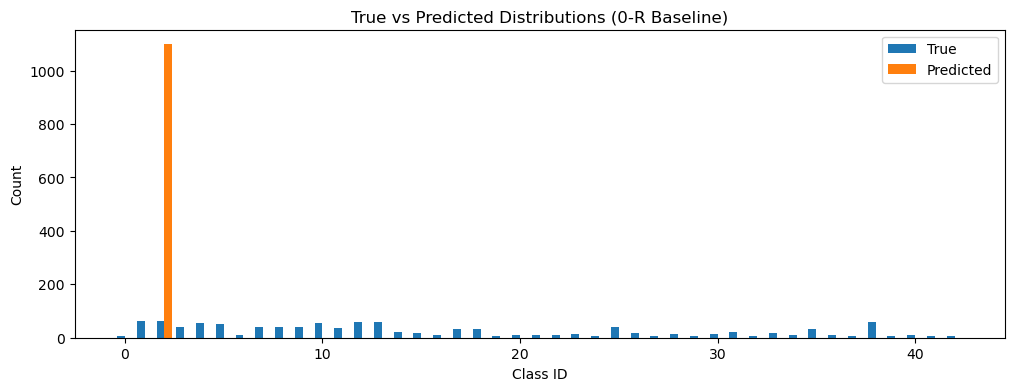

In [22]:
cm = confusion_matrix(y_test, y_pred_0r)
classes = np.unique(y_test)

true_counts     = np.bincount(y_test, minlength=43)
pred_counts     = np.bincount(y_pred_0r, minlength=43)
classes         = np.arange(43)

width = 0.4
plt.figure(figsize=(12,4))
plt.bar(classes - width/2, true_counts,  width, label='True')
plt.bar(classes + width/2, pred_counts,  width, label='Predicted')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.title('True vs Predicted Distributions (0-R Baseline)')
plt.legend()
plt.show()

# <span style="font-size:18px;">k-NN</span>

In [24]:
# Train model using k-NN
# Fine-tunning parameters (neighbors, distance)
N = len(combined_df)
root = int(np.sqrt(N))  
k_values = list(range(1, root * 2 + 1, 2))  
param_grid = {
    'n_neighbors': k_values,
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Initialize KNN estimator
knn = KNeighborsClassifier(n_jobs=-1)

# Set up GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Run grid search
grid_search.fit(X_train, y_train)

# Display best parameters and corresponding score
print(f"Best parameters: {grid_search.best_params_}")

# Apply best parameters
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'] , metric = grid_search.best_params_['metric'] , n_jobs=-1)
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Train on full training set and evaluate on test set
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"k-NN Hold-out accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print(f"k-NN Hold-out precision: {precision_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(f"k-NN Hold-out recall: {recall_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Fitting 5 folds for each of 222 candidates, totalling 1110 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1}
k-NN Hold-out accuracy: 0.791

k-NN Hold-out precision: 0.809
k-NN Hold-out recall: 0.775
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.84      0.82      0.83        62
           2       0.75      0.84      0.79        63
           3       0.60      0.64      0.62        39
           4       0.70      0.78      0.74        55
           5       0.62      0.79      0.69        52
           6       1.00      0.83      0.91        12
           7       0.73      0.90      0.81        40
           8       0.61      0.77      0.68        39
           9       0.85      0.68      0.76        41
          10       0.89      0.75      0.82        56
          11       0.77      0.62      0.69        37
          12       0.96      0.85      0.90        59
      

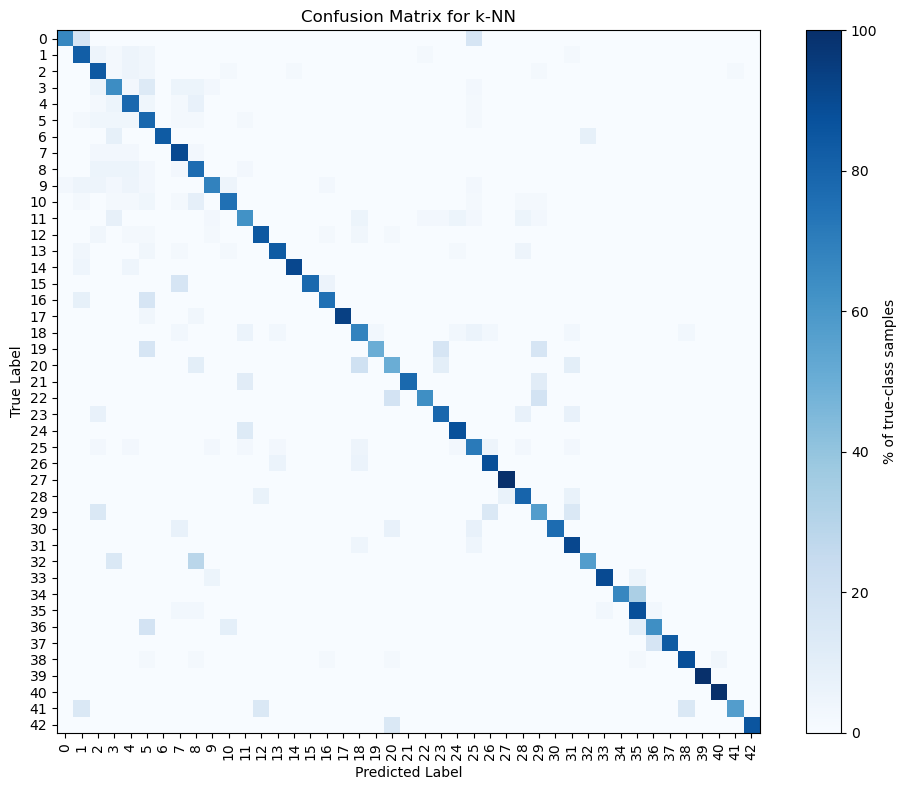

In [25]:
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# Convert to percentage
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
plt.title('Confusion Matrix for k-NN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=90)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.colorbar(label='% of true-class samples')
plt.tight_layout()
plt.show()

# <span style="font-size:18px;">Decision Tree</span>

In [27]:
# Set up hyperparameter search
dt_base = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_dt.fit(X_train, y_train)
print("Best DT params:", grid_dt.best_params_)

y_pred = grid_dt.predict(X_test)
print(f"Decision Tree Hold-out Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Decision Tree Hold-out precision: {precision_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(f"Decision Tree Hold-out recall: {recall_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(classification_report(y_test, y_pred, zero_division=0))



Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best DT params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Hold-out Accuracy: 0.560
Decision Tree Hold-out precision: 0.497
Decision Tree Hold-out recall: 0.493
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.53      0.42      0.47        62
           2       0.40      0.52      0.45        63
           3       0.38      0.38      0.38        39
           4       0.36      0.35      0.35        55
           5       0.38      0.35      0.36        52
           6       0.89      0.67      0.76        12
           7       0.43      0.50      0.47        40
           8       0.49      0.44      0.46        39
           9       0.71      0.54      0.61        41
          10       0.60      0.66      0.63        56
          11       0.35      0.35      0.35        37
          12       0.96      0.83   

# <span style="font-size:18px;">Bagging Decision Tree</span>

In [29]:
best_params = grid_dt.best_params_

best_tree = DecisionTreeClassifier(
    **best_params,
    random_state=42
)

bag_dt = BaggingClassifier(
    estimator=best_tree,  
    n_estimators=50,
    max_samples=0.8,
    random_state=42,
    n_jobs=-1
)
bag_dt.fit(X_train, y_train)
y_bag = bag_dt.predict(X_test)
print(f"Bagged DT Hold-out Accuracy: {accuracy_score(y_test, y_bag):.3f}")
print(f"Bagged DT Hold-out precision: {precision_score(y_test, y_bag, average='macro', zero_division=0):.3f}")
print(f"Bagged DT Hold-out recall: {recall_score(y_test, y_bag, average='macro', zero_division=0):.3f}")
print(classification_report(y_test, y_bag, zero_division=0))

Bagged DT Hold-out Accuracy: 0.738
Bagged DT Hold-out precision: 0.755
Bagged DT Hold-out recall: 0.634
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.59      0.82      0.68        62
           2       0.68      0.68      0.68        63
           3       0.66      0.59      0.62        39
           4       0.68      0.69      0.68        55
           5       0.65      0.62      0.63        52
           6       1.00      0.75      0.86        12
           7       0.63      0.68      0.65        40
           8       0.73      0.56      0.64        39
           9       0.68      0.73      0.71        41
          10       0.70      0.84      0.76        56
          11       0.38      0.68      0.49        37
          12       0.97      1.00      0.98        59
          13       1.00      0.97      0.98        60
          14       0.95      0.82      0.88        22
          15       0.80      0.

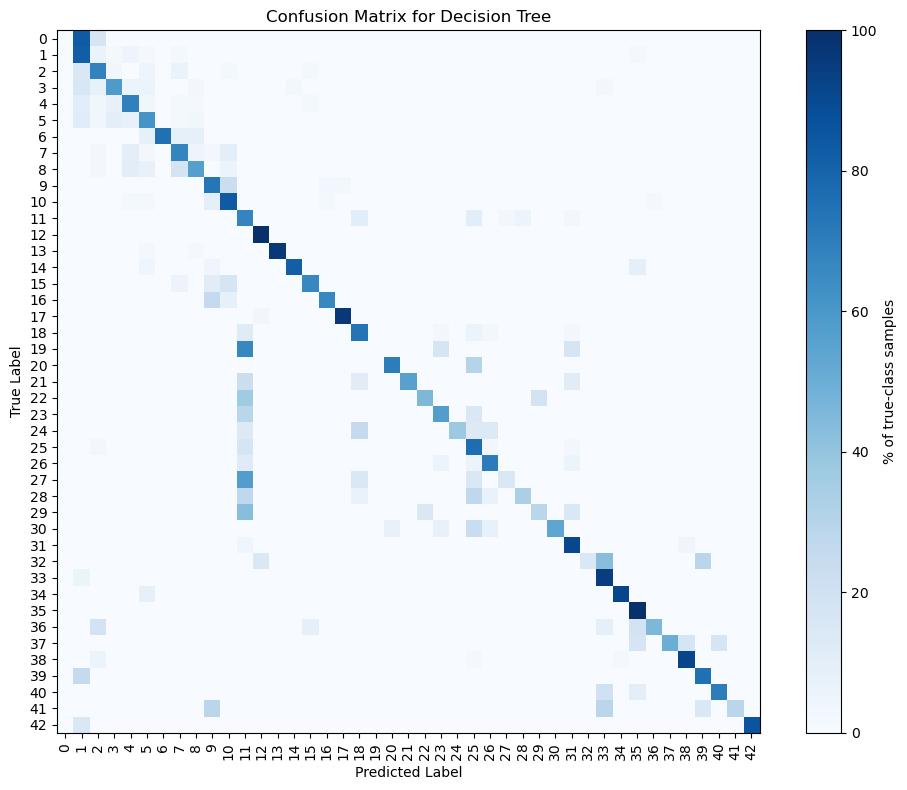

In [30]:
cm = confusion_matrix(y_test, y_bag)
classes = np.unique(y_test)

# Convert to percentage
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=90)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.colorbar(label='% of true-class samples')
plt.tight_layout()
plt.show()

# <span style="font-size:18px;">Random Forest</span>

Fitting 3 folds for each of 30 candidates, totalling 90 fits

--- RF Hyperparameters ---
Best params: {'max_features': 0.2, 'n_estimators': 495}
Best CV accuracy: 0.757
OOB score: 0.791

RF hold-out accuracy: 0.821
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.70      0.89      0.78        62
           2       0.76      0.81      0.78        63
           3       0.77      0.62      0.69        39
           4       0.73      0.75      0.74        55
           5       0.70      0.71      0.70        52
           6       1.00      0.92      0.96        12
           7       0.76      0.78      0.77        40
           8       0.90      0.67      0.76        39
           9       0.85      0.83      0.84        41
          10       0.76      0.93      0.84        56
          11       0.51      0.78      0.62        37
          12       0.97      1.00      0.98        59
          13       1.00     

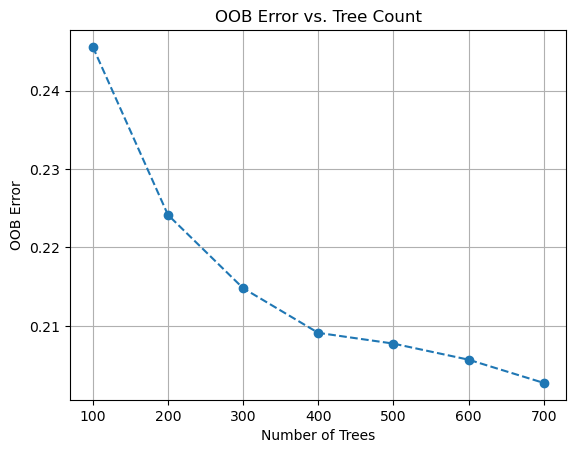

Optimal number of trees: 700

Final RF hold-out accuracy: 0.825
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.67      0.89      0.76        62
           2       0.81      0.81      0.81        63
           3       0.77      0.62      0.69        39
           4       0.75      0.80      0.77        55
           5       0.71      0.69      0.70        52
           6       1.00      0.92      0.96        12
           7       0.79      0.78      0.78        40
           8       0.87      0.67      0.75        39
           9       0.81      0.85      0.83        41
          10       0.79      0.93      0.85        56
          11       0.53      0.81      0.64        37
          12       0.98      1.00      0.99        59
          13       1.00      1.00      1.00        60
          14       1.00      0.95      0.98        22
          15       1.00      0.89      0.94        18
          16     

In [32]:
# Build RF using those DT settings 
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    max_depth         = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf  = best_params['min_samples_leaf'],
)

# Tune number of trees and feature‐subsampling:
param_dist_rf = {
    'n_estimators': randint(50, 501),             
    'max_features': ['sqrt', 'log2', 0.2, 0.5],    
}

rand_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=30,          
    cv=3,               
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rand_search_rf.fit(X_train, y_train)

print("\n--- RF Hyperparameters ---")
print("Best params:", rand_search_rf.best_params_)
print(f"Best CV accuracy: {rand_search_rf.best_score_:.3f}")
print(f"OOB score: {rand_search_rf.best_estimator_.oob_score_:.3f}")

# Initial evaluation on validation set
best_rf = rand_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)
print(f"\nRF hold-out accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, zero_division=0))

# Tune number of trees via OOB error 
tree_counts = [100, 200, 300, 400, 500, 600, 700]
oob_errors = []

for B in tree_counts:
    rfB = RandomForestClassifier(
        n_estimators=B,
        random_state=42,
        n_jobs=-1,
        oob_score=True,
        **best_params,                      
        max_features=rand_search_rf.best_params_['max_features']
    )
    rfB.fit(X_train, y_train)
    oob_errors.append(1 - rfB.oob_score_)

# Plot OOB error curve
plt.plot(tree_counts, oob_errors, 'o--')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Tree Count')
plt.grid(True)
plt.show()

# Pick best B
best_B = tree_counts[np.argmin(oob_errors)]
print(f"Optimal number of trees: {best_B}")

# Final RF
final_rf = RandomForestClassifier(
    n_estimators=best_B,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    **best_params,
    max_features=rand_search_rf.best_params_['max_features']
)
final_rf.fit(X_train, y_train)

# Final evaluation
y_final = final_rf.predict(X_test)
print(f"\nFinal RF hold-out accuracy: {accuracy_score(y_test, y_final):.3f}")
print(classification_report(y_test, y_final, zero_division=0))


Random Forest Hold-out accuracy: 0.825
Random Forest Hold-out precision: 0.863
Random Forest Hold-out recall: 0.745


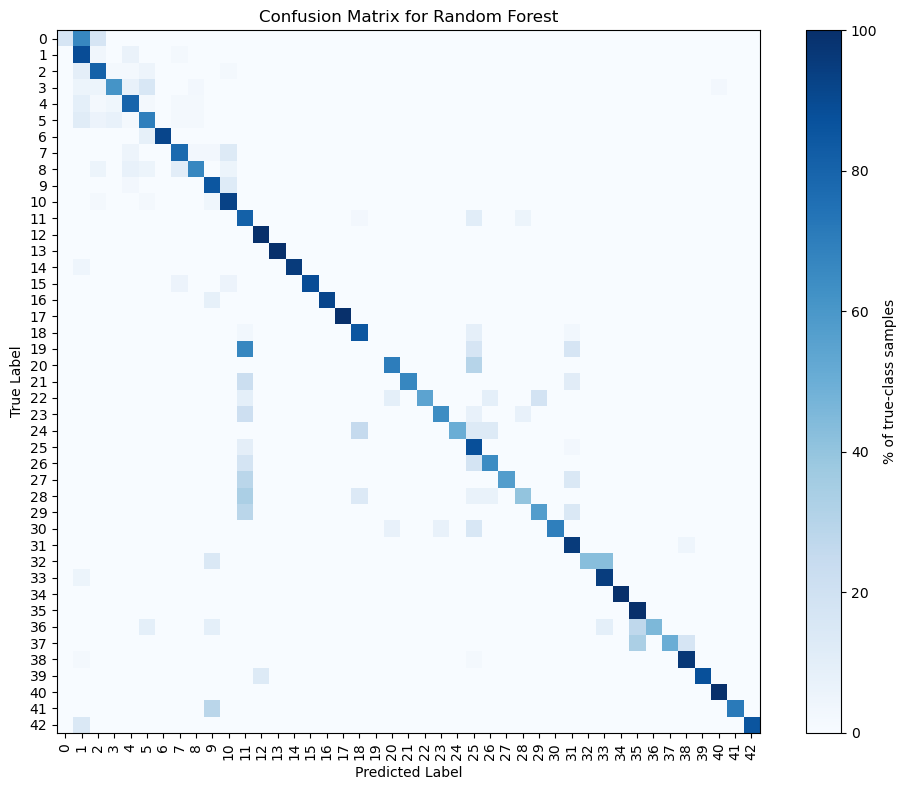

In [33]:
print(f"Random Forest Hold-out accuracy: {accuracy_score(y_test, y_final):.3f}")
print(f"Random Forest Hold-out precision: {precision_score(y_test, y_final, average='macro', zero_division=0):.3f}")
print(f"Random Forest Hold-out recall: {recall_score(y_test, y_final, average='macro', zero_division=0):.3f}")

cm = confusion_matrix(y_test, y_final)
classes = np.unique(y_test)

# Convert to percentage
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=90)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.colorbar(label='% of true-class samples')
plt.tight_layout()
plt.show()

# <span style="font-size:18px;">Weighted Ensemble</span>

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Level-0 Models for stacking
estimators = [
    ('knn', knn),
    ('rf',  final_rf)
]
# Precompute out-of-fold (OOF) meta-features for stacking 
meta_features = []
for name, est in estimators:
    oof = cross_val_predict(
        est, X_train, y_train,
        cv=3,
        method='predict_proba',
        n_jobs=-1
    )
    meta_features.append(oof)

# Combine into a single meta-feature matrix
meta_X = np.hstack(meta_features)

# Tune the meta-learner with RandomizedSearchCV
param_dist = {
    'C': np.logspace(-2, 2, 20)  # from 0.01 to 100
}

meta_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=500, random_state=42),
    param_distributions=param_dist,
    n_iter=10,        
    cv=3,             # 3-fold CV
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
meta_search.fit(meta_X, y_train)

print("Best meta-learner params:", meta_search.best_params_)
print(f"Meta-learner CV accuracy: {meta_search.best_score_:.3f}")

# Retrain base learners on the full training set 
for name, est in estimators:
    est.fit(X_train, y_train)

# Build the test meta-feature matrix 
test_meta = np.hstack([
    est.predict_proba(X_test)
    for _, est in estimators
])

# Final prediction using the tuned meta-learner
best_meta = meta_search.best_estimator_
y_pred = best_meta.predict(test_meta)

# Evaluate final stacked model
print("Stacked model classification report:\n",
      classification_report(y_test, y_pred, zero_division=0))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best meta-learner params: {'C': 61.584821106602604}
Meta-learner CV accuracy: 0.785
Stacked model classification report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.90      0.84      0.87        62
           2       0.84      0.84      0.84        63
           3       0.81      0.64      0.71        39
           4       0.81      0.91      0.85        55
           5       0.75      0.85      0.79        52
           6       1.00      1.00      1.00        12
           7       0.79      0.85      0.82        40
           8       0.90      0.69      0.78        39
           9       0.93      0.90      0.91        41
          10       0.83      0.93      0.87        56
          11       0.74      0.76      0.75        37
          12       1.00      0.98      0.99        59
          13       1.00      1.00      1.00        60
      


Stacked model hold-out accuracy: 0.872
Stacked model Hold-out precision: 0.868
Stacked model Hold-out recall: 0.845


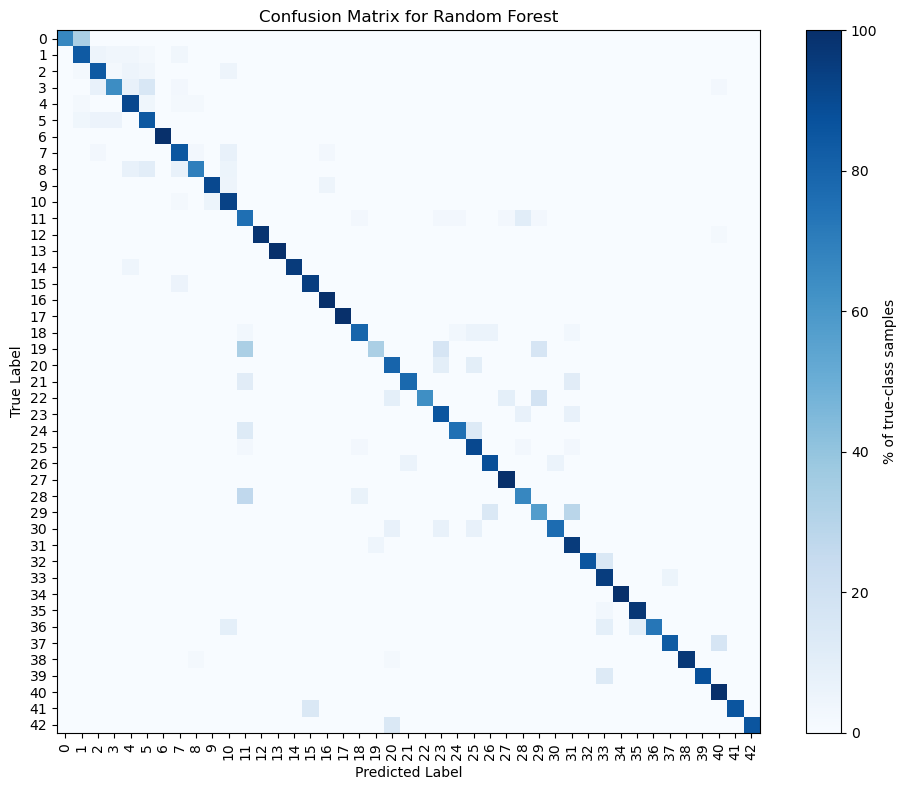

In [36]:
# Graph
print(f"\nStacked model hold-out accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Stacked model Hold-out precision: {precision_score(y_test, y_pred, average='macro', zero_division=0):.3f}")
print(f"Stacked model Hold-out recall: {recall_score(y_test, y_pred, average='macro', zero_division=0):.3f}")

cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

# Convert to percentage
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues', vmin=0, vmax=100)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(classes)), labels=classes, rotation=90)
plt.yticks(ticks=range(len(classes)), labels=classes)
plt.colorbar(label='% of true-class samples')
plt.tight_layout()
plt.show()



# Official model to have on Kaggle

# <span style="font-size:18px;">Add features to test</span>

In [39]:
IMG_DIR = r'C:\Users\Admin\Documents\COMP30027-Proj2\test'

# Create new feature dataframe
shape_feats = test_data['image_path'].apply(extract_shape_feats).tolist()
circular_feats = test_data['image_path'].apply(extract_fill_circularity).tolist()
circular_cols = ['image_path', 'fill_ratio', 'circularity']
shape_cols = ['image_path', 'area', 'perimeter', 'aspect_ratio', 'solidity', 'eccentricity']
shape_df = pd.DataFrame(shape_feats, columns=shape_cols, index=test_data.index)
circular_df = pd.DataFrame(circular_feats, columns=circular_cols, index=test_data.index)
test_sh = (test_data.merge(shape_df, on='image_path', how = 'inner')).drop(columns=['ClassId', "id"])


In [49]:
test_df = (test_data
           .merge(test_af, on='image_path', how='inner')
           .merge(test_ch, on='image_path', how='inner')
           .merge(test_hp, on='image_path', how='inner')
           .merge(test_sh, on='image_path', how='inner')
           ).drop(columns=['ClassId'])

# Load persistence files
with open('impute_stats.pkl','rb') as f:
    stats = pickle.load(f)
with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)

mean_vals        = stats['mean_vals']
mode_vals        = stats['mode_vals']
numeric_cols     = stats['numeric_cols']
categorical_cols = stats['categorical_cols']

# Impute missing in test_df exactly as before
for col in test_df.columns:
    if test_df[col].isnull().any():
        if col in numeric_cols:
            test_df[col] = test_df[col].fillna(mean_vals[col])
        else:
            test_df[col] = test_df[col].fillna(mode_vals[col])

# Scale numeric columns
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

X_test_db = test_df[X.columns]
meta_feats_test = []
for name, est in estimators:
    proba = est.predict_proba(X_test_db)           
    meta_feats_test.append(proba)

meta_test = np.hstack(meta_feats_test) 

## STACKING MODEL ON TEST SET
y_test_db = best_meta.predict(meta_test)

# Display sample predictions and distribution
pred_df = pd.DataFrame({'id': test_df['id'], 'Predicted_ClassId': y_test_db})
print("\nSample Test DB Predictions:")
print(pred_df.head(10))
print("\nPrediction Distribution:")
print(pred_df['Predicted_ClassId'].value_counts().sort_index())

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'id': test_df['id'],
    'ClassId': y_test_db
})

submission = pred_df.rename(columns={'id': 'id', 'ClassId': 'ClassId'})
submission.to_csv('stack.csv', index=False)
print("SAVED")


Sample Test DB Predictions:
     id  Predicted_ClassId
0   661                 12
1  4477                 16
2  1046                 39
3   631                  2
4  6533                  3
5  2899                 31
6  1941                 38
7  5749                  4
8   588                 11
9  1333                 16

Prediction Distribution:
Predicted_ClassId
0      14
1     136
2     137
3      82
4     112
5     123
6      13
7      73
8      88
9      78
10    156
11    105
12    121
13    127
14     26
15     38
16     49
17     66
18     81
19     14
20     20
21     16
22      7
23     43
24      7
25     91
26     39
27      6
28     30
29     13
30     28
31     39
32      7
33     41
34     19
35     60
36     19
37     18
38    138
39     16
40     30
41      7
42     20
Name: count, dtype: int64
SAVED


In [51]:
## ZEROR ON TEST SET
y_test_db = best_0r.predict(meta_test)

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'id': test_df['id'],
    'ClassId': y_test_db
})

# Display sample predictions and distribution
pred_df = pd.DataFrame({'id': test_df['id'], 'Predicted_ClassId': y_test_db})
print("\nSample Test DB Predictions:")
print(pred_df.head(10))
print("\nPrediction Distribution:")
print(pred_df['Predicted_ClassId'].value_counts().sort_index())

submission = pred_df.rename(columns={'id': 'id', 'ClassId': 'ClassId'})
submission.to_csv('ZeroR.csv', index=False)
print("SAVED")


Sample Test DB Predictions:
     id  Predicted_ClassId
0   661                  2
1  4477                  2
2  1046                  2
3   631                  2
4  6533                  2
5  2899                  2
6  1941                  2
7  5749                  2
8   588                  2
9  1333                  2

Prediction Distribution:
Predicted_ClassId
2    2353
Name: count, dtype: int64
SAVED


In [53]:
## k-NN ON TEST SET
y_test_db = knn.predict(X_test_db)

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'id': test_df['id'],
    'ClassId': y_test_db
})

# Display sample predictions and distribution
pred_df = pd.DataFrame({'id': test_df['id'], 'Predicted_ClassId': y_test_db})
print("\nSample Test DB Predictions:")
print(pred_df.head(10))
print("\nPrediction Distribution:")
print(pred_df['Predicted_ClassId'].value_counts().sort_index())

submission = pred_df.rename(columns={'id': 'id', 'ClassId': 'ClassId'})
submission.to_csv('k-NN.csv', index=False)
print("SAVED")


Sample Test DB Predictions:
     id  Predicted_ClassId
0   661                 12
1  4477                  1
2  1046                 39
3   631                  2
4  6533                  7
5  2899                 31
6  1941                 38
7  5749                  4
8   588                 11
9  1333                 16

Prediction Distribution:
Predicted_ClassId
0      17
1     124
2     171
3     107
4     160
5     111
6      25
7     100
8     114
9      85
10    121
11     90
12     98
13    107
14     29
15     20
16     23
17     63
18     71
19     14
20     22
21     19
22     10
23     37
24     14
25     92
26     36
27     14
28     28
29     15
30     22
31     46
32     11
33     35
34     18
35     71
36     20
37     12
38    117
39     20
40     19
41      8
42     17
Name: count, dtype: int64
SAVED


In [55]:
## BAGGED DECISION TREE ON TEST SET
y_test_db = bag_dt.predict(X_test_db)

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'id': test_df['id'],
    'ClassId': y_test_db
})

# Display sample predictions and distribution
pred_df = pd.DataFrame({'id': test_df['id'], 'Predicted_ClassId': y_test_db})
print("\nSample Test DB Predictions:")
print(pred_df.head(10))
print("\nPrediction Distribution:")
print(pred_df['Predicted_ClassId'].value_counts().sort_index())

submission = pred_df.rename(columns={'id': 'id', 'ClassId': 'ClassId'})
submission.to_csv('Bagging Decision Tree.csv', index=False)
print("SAVED")


Sample Test DB Predictions:
     id  Predicted_ClassId
0   661                 12
1  4477                  9
2  1046                  2
3   631                  4
4  6533                  3
5  2899                 25
6  1941                 38
7  5749                  1
8   588                  1
9  1333                 12

Prediction Distribution:
Predicted_ClassId
1     235
2     175
3      74
4      93
5     104
6       9
7      61
8      88
9     138
10    173
11    176
12    158
13    128
14     40
15     13
16     33
17     64
18     79
19      2
20     17
21      2
22      9
23     14
24      7
25    112
26     16
27      1
28      9
29      1
30     15
31     52
32      1
33     23
34      3
35     24
36     27
37      7
38    121
39      6
40     42
42      1
Name: count, dtype: int64
SAVED


In [57]:
## RANDOM FOREST ON TEST SET
y_test_db = final_rf.predict(X_test_db)

# Create DataFrame of predictions
pred_df = pd.DataFrame({
    'id': test_df['id'],
    'ClassId': y_test_db
})

# Display sample predictions and distribution
pred_df = pd.DataFrame({'id': test_df['id'], 'Predicted_ClassId': y_test_db})
print("\nSample Test DB Predictions:")
print(pred_df.head(10))
print("\nPrediction Distribution:")
print(pred_df['Predicted_ClassId'].value_counts().sort_index())

submission = pred_df.rename(columns={'id': 'id', 'ClassId': 'ClassId'})
submission.to_csv('Random Forest.csv', index=False)
print("SAVED")


Sample Test DB Predictions:
     id  Predicted_ClassId
0   661                 12
1  4477                  9
2  1046                  2
3   631                  4
4  6533                  3
5  2899                 25
6  1941                 38
7  5749                  1
8   588                 28
9  1333                 12

Prediction Distribution:
Predicted_ClassId
1     219
2     184
3      53
4     102
5      99
6       3
7      54
8      93
9     138
10    217
11    151
12    186
13    131
14     21
15      7
16      8
17     70
18     77
19      1
20     18
21      4
22      4
23     20
24      2
25    143
26     28
28     14
29      5
30      9
31     35
33     11
34     12
35     59
36      8
37      3
38    136
39      4
40     21
41      2
42      1
Name: count, dtype: int64
SAVED
